In [7]:
# --- Setup & Imports ---
import os, sys
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from typing import Dict, Any, List, Tuple, Callable, Optional, TypedDict
from dataclasses import dataclass
import json

# --- 1. Pfad-Setup ---
def _locate_repo_root(start: Path) -> Path:
    cur = start.resolve()
    for _ in range(5):  # walk up to 5 levels
        if (cur / 'src').exists():
            return cur
        if cur.parent == cur:
            break
        cur = cur.parent
    return start.resolve()

NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = _locate_repo_root(NOTEBOOK_DIR)
os.environ['PROJECT_ROOT'] = str(PROJECT_ROOT)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# --- Import necessary functions and models ---
from src.config import GlobalConfig, DEFAULT_CORR_SPEC, OUTPUTS
from src.io_timesplits import load_target, load_ifo_features, _clean_column_name
from src.features import (
    select_lags_per_feature, build_engineered_matrix,
    screen_k1, redundancy_reduce_greedy,
    _nuisance_matrix, _residualize_vec, pw_corr, _align_D_to_taus
)
from src.models.ET import ForecastModel as ETModel
from src.models.LGBM import ForecastModel as LGBMModel
from sklearn.linear_model import ElasticNet # Import für die lokale Klasse

print('PROJECT_ROOT =', PROJECT_ROOT)

# --- GEÄNDERT: Output-Verzeichnis ---
# Basis-Output-Verzeichnis bleibt gleich
BASE_OUTPUT_DIR = OUTPUTS / "feature_importance"
# Neuer Unterordner für diese spezifische Datei
OUTPUT_DIR = BASE_OUTPUT_DIR / "outputs_no_missing"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print('Output Directory =', OUTPUT_DIR)


# --- NEUE LOKALE ENModel-Klasse (nur für Feature Importance) ---
class ENModel:
    """Lokale EN-Wrapper-Klasse, die fix-lambda ElasticNet statt ElasticNetCV verwendet."""
    def __init__(self, params: Optional[Dict[str, Any]] = None):
        self.params = dict(params or {})
        self._reg = None
        self._backend_name = "elastic_net_fixed_lambda"
        self._feature_names: Optional[List[str]] = None

        # L1-Mischparameter (aus HP_EN 'alpha')
        self._l1_ratio = float(self.params.get("alpha", 0.5))
        # Fixe Regularisierungsstärke (aus HP_EN 'lambda')
        self._lambda = float(self.params.get("lambda", 0.1)) # 0.1 als Default

    @staticmethod
    def _clean(X):
        X = np.asarray(X, dtype=float)
        return np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0, copy=False)

    def fit(self, X, y, sample_weight=None):
        if isinstance(X, pd.DataFrame):
            self._feature_names = X.columns.tolist()
            X_np = X.values
        else:
            X_np = np.asarray(X)
            self._feature_names = [f"feature_{i}" for i in range(X_np.shape[1])]

        X_np = self._clean(X_np)
        y_np = np.asarray(y, dtype=float).ravel()

        self._reg = ElasticNet(
            alpha=self._lambda,      # Setzt die fixe Regularisierungsstärke
            l1_ratio=self._l1_ratio, # Setzt den Misch-Parameter
            random_state=42,
            fit_intercept=True
        )
        self._reg.fit(X_np, y_np, sample_weight=sample_weight)
        return self
# --- ENDE NEUE LOKALE KLASSE ---


# --- 2. Konfiguration ---
REDUNDANCY_THRESHOLD = 0.90  # Schwelle für den finalen Redundanzfilter (für Mean Importance)
FINAL_TOP_K_MEAN = 20      # Gewünschte Anzahl diverser Features (für Mean Importance)
TOP_N_PER_MODEL = 20       # Top N für die Schnittmengen-Methode

# --- Feste Hyperparameter für die Importance-Modelle ---
# KORRIGIERT: HP_EN enthält jetzt 'lambda' für die neue lokale Klasse
HP_EN = {'alpha': 0.5, 'lambda': 0.1} # 0.1 ist ein "repräsentativer" Wert
HP_ET = {'n_estimators': 100, 'max_features': 0.1, 'min_samples_leaf': 10}
HP_LGBM = {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 31,
           'colsample_bytree': 0.1, 'min_child_samples': 20,
           'early_stopping_rounds': None, 'es_val_tail_size': 12} # es_val_tail_size wird von LGBM.py intern genutzt

# --- 3. Daten laden ---
y = load_target()
X_ifo = load_ifo_features() # Dies lädt die volle (ca. 2160) Feature-Datei

idx = y.index.intersection(X_ifo.index)
y, X_ifo = y.loc[idx], X_ifo.loc[idx]
T = len(y)
print('Daten geladen. Shapes:', X_ifo.shape, y.shape)

# --- 4. Modifizierte Feature-Pipeline (nur bester Lag, kein RM3, kein Top-K) ---
def run_feature_pipeline_for_importance(
    X: pd.DataFrame, y: pd.Series, t_origin: int,
    # NEU: Option, um lag_map für Job 1 wiederzuverwenden
    lag_map: Optional[Dict[str, List[int]]] = None
) -> Tuple[pd.DataFrame, pd.Series, Dict[str, List[int]]]:
    """
    Führt FE durch (nur bester Lag), aber KEIN RM3, KEIN Top-K Screening, KEINEN Redundanzfilter/DR.
    Gibt die resultierende Feature-Matrix und den Zielvektor für den Trainingszeitraum zurück.
    """
    I_t = t_origin + 1
    corr_spec = DEFAULT_CORR_SPEC

    if lag_map is None:
        # 1) Lag-Selektion (nur wenn nicht übergeben)
        lag_candidates = tuple(range(0, 12)) # <-- GEÄNDERT
        top_k_lags = 1

        lag_map, _, D, taus = select_lags_per_feature(
            X, y, I_t=I_t, L=lag_candidates, k=top_k_lags, corr_spec=corr_spec
        )
    else:
        # Verwende die übergebene lag_map, aber hole D und taus für diesen I_t
        _, _, D, taus = select_lags_per_feature(
            X, y, I_t=I_t, L=(), k=0, corr_spec=corr_spec
        )


    # 2) Feature Engineering
    X_eng = build_engineered_matrix(X, lag_map)
    if X_eng.empty:
         return pd.DataFrame(), pd.Series(dtype=float), lag_map

    # 3) Head-Trim
    def _lag_of(col):
        try: return int(str(col).split('__lag')[-1])
        except: return 0
    head_needed = max([_lag_of(c) for c in X_eng.columns] + [0])

    # KORRIGIERT: Head-Trim Off-by-One (>= 0 statt >= 1)
    taus_model_mask = (taus - head_needed >= 0)
    if np.sum(taus_model_mask) == 0:
        taus_model = taus[-1:].copy() if taus.size > 0 else np.array([], dtype=int)
    else:
        taus_model = taus[taus_model_mask]

    if len(taus_model) == 0:
         return pd.DataFrame(), pd.Series(dtype=float), lag_map

    X_train_final = X_eng.iloc[taus_model, :].copy()
    y_train_final = y.shift(-1).iloc[taus_model].copy()
    if X_train_final.empty:
        return pd.DataFrame(), pd.Series(dtype=float), lag_map

    # NaN/Inf sicherstellen (wichtig, falls Lag-Selektion NAs erzeugt)
    X_train_final = X_train_final.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    # Spaltennamen sind bereits durch load_ifo_features() bereinigt

    return X_train_final, y_train_final, lag_map

# --- NEU: Job 1 - Speichere die vollständige gelaggte Feature-Matrix ---
print("\n" + "="*20)
print("--- STARTING JOB 1: Build and save full lagged feature matrix ---")
print("="*20)

# 1. Finde die "beste Lag"-Map basierend auf dem *gesamten* Datensatz
# (t_origin = T-2 ist der letzte gültige Origin für Training)
t_ref_full = T - 2
I_t_full = t_ref_full + 1
lag_map_full, _, _, _ = select_lags_per_feature(
    X_ifo, y, I_t=I_t_full,
    L=tuple(range(0, 12)), # <-- GEÄNDERT
    k=1,
    corr_spec=DEFAULT_CORR_SPEC
)
print(f"Lag map based on t={t_ref_full} (I_t={I_t_full}) created.")

# 2. Baue die Matrix mit dieser finalen Lag-Map
X_eng_full = build_engineered_matrix(X_ifo, lag_map_full)
X_eng_full = X_eng_full.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# 3. Speichere die Datei (Parquet ist effizienter)
lagged_features_path = OUTPUT_DIR / "X_eng_full_lagged.parquet"
X_eng_full.to_parquet(lagged_features_path)
print(f"Full lagged feature matrix saved to: {lagged_features_path}")
print(f"Shape of saved matrix: {X_eng_full.shape}")
# --- ENDE JOB 1 ---


# --- 5. Helper Function für Rolling Importance & Aggregation (ÜBERARBEITET) ---
def perform_rolling_importance(start_origin: int, end_origin: int, run_name: str) -> Tuple[pd.DataFrame, Dict[str, pd.DataFrame]]:
    """Führt die Rolling Importance Schleife durch und gibt aggregierte, NORMALISIERTE Wichtigkeit zurück."""
    all_importances = {'EN': [], 'ET': [], 'LGBM': []}
    origins = range(start_origin, end_origin + 1) # Voller Lauf, kein Step
    all_feature_names_seen = set() # Track all features encountered

    # Verwende die in Job 1 berechnete, fixe Lag-Map für alle Iterationen
    # Dies stellt sicher, dass die Feature-Namen (Spalten) über die Zeit konsistent sind.
    global lag_map_full

    for t in tqdm(origins, desc=f"Rolling Importance ({start_origin}-{end_origin})"):
        if t >= T - 1: break

        # Verwende die fixe lag_map_full, anstatt sie bei jedem t neu zu berechnen
        X_tr, y_tr, _ = run_feature_pipeline_for_importance(X_ifo, y, t, lag_map=lag_map_full)

        if X_tr.empty or y_tr.empty or len(y_tr) < 20: # Prüfe auf mind. Datenpunkte
            print(f"Skipping origin t={t} due to insufficient data after pipeline.")
            continue

        feature_names = X_tr.columns.tolist()
        all_feature_names_seen.update(feature_names) # Sollte jetzt immer gleich sein

        results_t = {'origin': t, 'date': y.index[t]}

        # Elastic Net (KORRIGIERT: Nutzt jetzt die lokale, schnelle Klasse)
        try:
            model_en = ENModel(HP_EN).fit(X_tr.copy(), y_tr.copy())
            coefs = model_en._reg.coef_
            results_t['EN'] = dict(zip(feature_names, np.abs(coefs)))
        except Exception as e:
            print(f"EN failed at t={t}: {e}")
            results_t['EN'] = {}

        # Extra Trees
        try:
            model_et = ETModel(HP_ET).fit(X_tr.copy(), y_tr.copy())
            results_t['ET'] = model_et.get_feature_importances()
        except Exception as e:
            print(f"ET failed at t={t}: {e}")
            results_t['ET'] = {}

        # LightGBM (Early Stopping Fix)
        try:
            model_lgbm = LGBMModel(HP_LGBM).fit(X_tr.copy(), y_tr.copy())
            results_t['LGBM'] = model_lgbm.get_feature_importances()
        except Exception as e:
            print(f"LGBM failed at t={t}: {e}")
            results_t['LGBM'] = {}

        all_importances['EN'].append(results_t.get('EN', {}))
        all_importances['ET'].append(results_t.get('ET', {}))
        all_importances['LGBM'].append(results_t.get('LGBM', {}))

    print(f"Rolling Importance Calculation ({start_origin}-{end_origin}) Done.")

    # --- Aggregation über die Zeit (ROBUSTER) ---
    valid_models = [m for m, imp_list in all_importances.items() if imp_list]

    if not valid_models:
        print("Warning: No importance results generated for any model.")
        return pd.DataFrame(), {}

    df_agg = pd.DataFrame(index=sorted(list(all_feature_names_seen)))
    all_raw_dfs: Dict[str, pd.DataFrame] = {} # Für Stabilitäts-Plot

    for model_name in valid_models:
        df_imp = pd.DataFrame(all_importances[model_name]).fillna(0.0)
        df_imp = df_imp.reindex(columns=df_agg.index, fill_value=0.0)

        # (Task 3): Speichere die rohe Zeitreihe der Wichtigkeiten
        all_raw_dfs[model_name] = df_imp.copy()
        raw_output_path = OUTPUT_DIR / f"raw_importance_{model_name}_{run_name}.csv"
        df_imp.to_csv(raw_output_path)
        print(f"Saved raw time series importance for {model_name} to: {raw_output_path}")

        df_agg[model_name] = df_imp.mean(axis=0)

    # Normalize per model
    df_agg_norm = df_agg.div(df_agg.sum(axis=0), axis=1).fillna(0.0)
    df_agg_norm['Mean_Importance'] = df_agg_norm.mean(axis=1)

    return df_agg_norm, all_raw_dfs

# --- 6. Helper Function für finale Top-K Auswahl (mittels Redundanzfilter) ---
def select_diverse_top_k(df_agg_norm: pd.DataFrame, redundancy_threshold: float, final_top_k: int, t_ref: int) -> List[str]:
    """Wählt die Top K diversen Features aus der aggregierten Importance (Mean)."""
    if df_agg_norm.empty: return []

    # Schritt A: Wähle Top N relevante Features
    N = min(len(df_agg_norm), 200)
    top_n_features = df_agg_norm.sort_values('Mean_Importance', ascending=False).head(N).index.tolist()
    print(f"Top {len(top_n_features)} Kandidaten basierend auf mittlerer Wichtigkeit ausgewählt.")

    # Schritt B: Wende Redundanzfilter an
    X_tr_ref, _, _ = run_feature_pipeline_for_importance(X_ifo, y, t_ref, lag_map=lag_map_full)

    valid_top_n = [f for f in top_n_features if f in X_tr_ref.columns]
    if not valid_top_n:
        print("Warnung: Keine der Top-N Features im Referenz-DataFrame gefunden.")
        return []
    X_top_n = X_tr_ref[valid_top_n].copy()

    # Nuisance Matrix D basierend auf Indizes von X_top_n
    original_indices = X_top_n.index
    y_lag1_aligned = y.shift(1).reindex(original_indices).fillna(0.0)
    D_top_n = np.vstack([np.ones(len(X_top_n)), y_lag1_aligned.values]).T
    local_taus = np.arange(len(X_top_n))

    # Sortiere nach Wichtigkeit
    scores_top_n = df_agg_norm.loc[valid_top_n, 'Mean_Importance'].to_dict()

    diverse_features = redundancy_reduce_greedy(
        X_sel=X_top_n,
        corr_spec=DEFAULT_CORR_SPEC,
        D=D_top_n,
        taus=local_taus,
        redundancy_param=redundancy_threshold,
        scores=scores_top_n
    )

    final_top_features = diverse_features[:final_top_k]
    return final_top_features

# ======================================================================
# --- RUN 1: Ex-Ante + Ex-Post (t=120 to T-2) ---
# ======================================================================
print("\n" + "="*20)
print("--- STARTING FULL IMPORTANCE RUN (t=120 to T-2) ---")
print("="*20)

# --- ÄNDERUNG (Task 1): Starte bei 120 ---
START_ORIGIN_FULL = 120
END_ORIGIN_FULL = T - 2 # Gehe bis zum vorletzten Punkt

df_agg_norm_full, raw_dfs_full = perform_rolling_importance(START_ORIGIN_FULL, END_ORIGIN_FULL, "full_run")

# --- Output 1: Top Features per Model (basierend auf vollem Lauf) ---
if not df_agg_norm_full.empty:
    top_en   = set(df_agg_norm_full.sort_values('EN', ascending=False).head(TOP_N_PER_MODEL).index)
    top_et   = set(df_agg_norm_full.sort_values('ET', ascending=False).head(TOP_N_PER_MODEL).index)
    top_lgbm = set(df_agg_norm_full.sort_values('LGBM', ascending=False).head(TOP_N_PER_MODEL).index)

    print(f"\n--- Top {TOP_N_PER_MODEL} Features per Model (Full Run) ---")
    for model_name, top_set in [('EN', top_en), ('ET', top_et), ('LGBM', top_lgbm)]:
        top_list = sorted(list(top_set))
        print(f"Top {len(top_list)} for {model_name}: {top_list[:3]}...")
        output_path_model = OUTPUT_DIR / f"top_features_{model_name}_full.json"
        with open(output_path_model, "w") as f:
            json.dump(top_list, f, indent=2)
        print(f"Saved {model_name} list to: {output_path_model}")

# --- Output 2: Top Mean Features (Diverse, basierend auf vollem Lauf) ---
final_top_features_mean_full = select_diverse_top_k(
    df_agg_norm_full, REDUNDANCY_THRESHOLD, FINAL_TOP_K_MEAN, t_ref=END_ORIGIN_FULL
)

print(f"\n--- Finale Top {len(final_top_features_mean_full)} Diverse Features (Full Run) ---")
for i, feat in enumerate(final_top_features_mean_full):
    print(f"{i+1}. {feat}")

output_path_mean_full = OUTPUT_DIR / "top_mean_features_full.json"
with open(output_path_mean_full, "w") as f:
    json.dump(final_top_features_mean_full, f, indent=2)
print(f"Saved mean diverse list to: {output_path_mean_full}")


# ======================================================================
# --- NEU: Job 3 - Erstelle Rolling Mean Importance File ---
# ======================================================================
print("\n" + "="*50)
print("--- STARTING JOB 3: Build and save Rolling Mean Importance (60m) ---")
print("="*50)

ROLLING_WINDOW_SIZE = 60

# 1. Lade alle rohen, normalisierten Mean-Importance-Zeitreihen
# (Diese wurden in perform_rolling_importance berechnet und gespeichert)
all_raw_dfs: Dict[str, pd.DataFrame] = {}
run_name = "full_run" # Wir nutzen den gerade abgeschlossenen Lauf
for model_name in ["EN", "ET", "LGBM"]:
    path = OUTPUT_DIR / f"raw_importance_{model_name}_{run_name}.csv"
    if path.exists():
        all_raw_dfs[model_name] = pd.read_csv(path, index_col=0)
    else:
        print(f"Warnung: Konnte {path} nicht finden. Überspringe Job 3.")
        all_raw_dfs = {} # Leeren, um Abbruch zu erzwingen
        break

if not all_raw_dfs:
    print("Keine rohen Wichtigkeits-Dateien gefunden. Überspringe Job 3.")
else:
    # 2. Kombiniere zu einem einzigen Mean-Importance DataFrame (pro Monat)
    print("Kombiniere rohe Wichtigkeiten (EN, ET, LGBM) zu einem Mean-Score...")

    # Nimm Index und Spalten aus einem der DFs
    base_index = all_raw_dfs["EN"].index
    base_columns = all_raw_dfs["EN"].columns

    # Normalisiere jedes Modell (pro Zeile/Monat), BEVOR es gemittelt wird
    df_norm_en = all_raw_dfs["EN"].div(all_raw_dfs["EN"].sum(axis=1), axis=0).fillna(0.0)
    df_norm_et = all_raw_dfs["ET"].div(all_raw_dfs["ET"].sum(axis=1), axis=0).fillna(0.0)
    df_norm_lgbm = all_raw_dfs["LGBM"].div(all_raw_dfs["LGBM"].sum(axis=1), axis=0).fillna(0.0)

    df_mean_imp_monthly = (df_norm_en + df_norm_et + df_norm_lgbm) / 3.0

    # --- HIER EINGEFÜGT: Speichere die rohe kombinierte CSV-Datei für den Plot-Chunk ---
    mean_raw_output_path = OUTPUT_DIR / f"raw_importance_MEAN_{run_name}.csv"
    df_mean_imp_monthly.to_csv(mean_raw_output_path)
    print(f"Saved raw time series importance for MEAN (Kombi) to: {mean_raw_output_path}")
    # --- ENDE EINFÜGEN ---

    # 3. Berechne den 60-Monats Rolling Mean
    print(f"Berechne {ROLLING_WINDOW_SIZE}-Monats Rolling Mean...")
    df_rolling_mean_imp = df_mean_imp_monthly.rolling(window=ROLLING_WINDOW_SIZE, min_periods=1).mean()

    # 4. Setze den Index auf die *Ziel-Daten* (t+1), für die diese Wichtigkeit gilt
    # Die Wichtigkeit bei Index 0 (t=120) basiert auf Daten bis 120, gilt also für Prognose t=121
    # Der Index von df_rolling_mean_imp (0, 1, 2...) muss auf die y-Zeitstempel gemappt werden

    # +1 weil der rolling mean für den *nächsten* Monat gilt
    target_dates = y.index[START_ORIGIN_FULL + 1 : END_ORIGIN_FULL + 2]

    if len(target_dates) == len(df_rolling_mean_imp):
        df_rolling_mean_imp.index = target_dates

        # Fülle den gesamten Zeitindex auf (erste 180 Zeilen werden NaN)
        df_rolling_mean_imp = df_rolling_mean_imp.reindex(y.index)

        # 5. Speichere die Datei
        rolling_imp_path = OUTPUT_DIR / f"rolling_mean_importance_{ROLLING_WINDOW_SIZE}m.parquet"
        df_rolling_mean_imp.to_parquet(rolling_imp_path)

        print(f"\nRolling Mean Importance (Shape: {df_rolling_mean_imp.shape}) gespeichert in:")
        print(rolling_imp_path)
        print("\nBeispiel-Daten (erste gültige Zeile bei t=180):")
        print(df_rolling_mean_imp.loc[y.index[180]:].dropna().head())
    else:
        print(f"Fehler: Länge der Zieldaten ({len(target_dates)}) passt nicht zur Länge des Rolling-DataFrames ({len(df_rolling_mean_imp)}).")


print("\nFeature Importance Analysis Complete.")

PROJECT_ROOT = /Users/jonasschernich/Documents/Masterarbeit/Code
Output Directory = /Users/jonasschernich/Documents/Masterarbeit/Code/outputs/feature_importance/outputs_no_missing
INFO in load_ifo_features: Renaming columns to ensure validity.
Daten geladen. Shapes: (407, 2160) (407,)

--- STARTING JOB 1: Build and save full lagged feature matrix ---
Lag map based on t=405 (I_t=406) created.
Full lagged feature matrix saved to: /Users/jonasschernich/Documents/Masterarbeit/Code/outputs/feature_importance/outputs_no_missing/X_eng_full_lagged.parquet
Shape of saved matrix: (407, 2160)

--- STARTING FULL IMPORTANCE RUN (t=120 to T-2) ---


Rolling Importance (120-405):   0%|          | 0/286 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.057e+00, tolerance: 2.056e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   0%|          | 1/286 [00:00<02:25,  1.96it/s]

LGBM failed at t=120: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.173e+00, tolerance: 2.085e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   1%|          | 2/286 [00:00<01:38,  2.90it/s]

LGBM failed at t=121: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.266e-01, tolerance: 2.111e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   1%|          | 3/286 [00:00<01:22,  3.44it/s]

LGBM failed at t=122: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.609e-01, tolerance: 2.111e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   1%|▏         | 4/286 [00:01<01:16,  3.68it/s]

LGBM failed at t=123: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.022e+00, tolerance: 2.174e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   2%|▏         | 5/286 [00:01<01:14,  3.77it/s]

LGBM failed at t=124: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.269e+00, tolerance: 2.236e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   2%|▏         | 6/286 [00:01<01:12,  3.85it/s]

LGBM failed at t=125: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.358e+00, tolerance: 2.248e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   2%|▏         | 7/286 [00:02<01:27,  3.20it/s]

LGBM failed at t=126: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.609e+00, tolerance: 2.281e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   3%|▎         | 8/286 [00:02<01:23,  3.33it/s]

LGBM failed at t=127: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.596e+00, tolerance: 2.289e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   3%|▎         | 9/286 [00:02<01:20,  3.45it/s]

LGBM failed at t=128: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.614e+00, tolerance: 2.296e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   3%|▎         | 10/286 [00:02<01:15,  3.66it/s]

LGBM failed at t=129: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.955e+00, tolerance: 2.300e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   4%|▍         | 11/286 [00:03<01:12,  3.79it/s]

LGBM failed at t=130: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.108e+00, tolerance: 2.306e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   4%|▍         | 12/286 [00:03<01:10,  3.89it/s]

LGBM failed at t=131: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.169e+00, tolerance: 2.308e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   5%|▍         | 13/286 [00:03<01:16,  3.55it/s]

LGBM failed at t=132: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.836e-01, tolerance: 2.309e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   5%|▍         | 14/286 [00:03<01:13,  3.70it/s]

LGBM failed at t=133: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.055e+00, tolerance: 2.316e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   5%|▌         | 15/286 [00:04<01:11,  3.82it/s]

LGBM failed at t=134: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.224e+00, tolerance: 2.348e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   6%|▌         | 16/286 [00:04<01:09,  3.86it/s]

LGBM failed at t=135: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.548e+00, tolerance: 2.369e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   6%|▌         | 17/286 [00:04<01:11,  3.75it/s]

LGBM failed at t=136: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e+00, tolerance: 2.410e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   6%|▋         | 18/286 [00:05<01:10,  3.83it/s]

LGBM failed at t=137: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.011e+00, tolerance: 2.418e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   7%|▋         | 19/286 [00:05<01:20,  3.33it/s]

LGBM failed at t=138: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.868e-01, tolerance: 2.430e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   7%|▋         | 20/286 [00:05<01:17,  3.44it/s]

LGBM failed at t=139: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.290e-01, tolerance: 2.457e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   7%|▋         | 21/286 [00:05<01:14,  3.55it/s]

LGBM failed at t=140: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.570e-01, tolerance: 2.509e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   8%|▊         | 22/286 [00:06<01:12,  3.65it/s]

LGBM failed at t=141: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.918e-01, tolerance: 2.521e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   8%|▊         | 23/286 [00:06<01:11,  3.65it/s]

LGBM failed at t=142: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.603e-01, tolerance: 2.521e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   8%|▊         | 24/286 [00:06<01:11,  3.66it/s]

LGBM failed at t=143: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.087e-01, tolerance: 2.525e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   9%|▊         | 25/286 [00:07<01:12,  3.62it/s]

LGBM failed at t=144: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.077e-01, tolerance: 2.531e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   9%|▉         | 26/286 [00:07<01:25,  3.04it/s]

LGBM failed at t=145: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.934e-01, tolerance: 2.536e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):   9%|▉         | 27/286 [00:07<01:19,  3.24it/s]

LGBM failed at t=146: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.268e-01, tolerance: 2.539e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  10%|▉         | 28/286 [00:07<01:16,  3.39it/s]

LGBM failed at t=147: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.845e-01, tolerance: 2.580e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  10%|█         | 29/286 [00:08<01:13,  3.51it/s]

LGBM failed at t=148: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.330e+00, tolerance: 2.633e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  10%|█         | 30/286 [00:08<01:11,  3.60it/s]

LGBM failed at t=149: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.105e+00, tolerance: 2.633e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  11%|█         | 31/286 [00:08<01:09,  3.67it/s]

LGBM failed at t=150: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.367e-01, tolerance: 2.692e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  11%|█         | 32/286 [00:09<01:16,  3.31it/s]

LGBM failed at t=151: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.080e-01, tolerance: 2.698e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  12%|█▏        | 33/286 [00:09<01:15,  3.36it/s]

LGBM failed at t=152: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.975e+00, tolerance: 2.698e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  12%|█▏        | 34/286 [00:09<01:13,  3.43it/s]

LGBM failed at t=153: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.865e+00, tolerance: 2.698e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  12%|█▏        | 35/286 [00:09<01:11,  3.50it/s]

LGBM failed at t=154: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.437e+00, tolerance: 2.699e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  13%|█▎        | 36/286 [00:10<01:10,  3.54it/s]

LGBM failed at t=155: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.405e+00, tolerance: 2.699e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  13%|█▎        | 37/286 [00:10<01:09,  3.59it/s]

LGBM failed at t=156: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.420e+00, tolerance: 2.710e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  13%|█▎        | 38/286 [00:10<01:16,  3.26it/s]

LGBM failed at t=157: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.369e+00, tolerance: 2.718e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  14%|█▎        | 39/286 [00:11<01:13,  3.38it/s]

LGBM failed at t=158: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.760e+00, tolerance: 2.722e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  14%|█▍        | 40/286 [00:11<01:11,  3.46it/s]

LGBM failed at t=159: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.564e+00, tolerance: 2.729e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  14%|█▍        | 41/286 [00:11<01:10,  3.50it/s]

LGBM failed at t=160: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.425e+00, tolerance: 2.739e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  15%|█▍        | 42/286 [00:11<01:09,  3.52it/s]

LGBM failed at t=161: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.759e+00, tolerance: 2.739e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  15%|█▌        | 43/286 [00:12<01:08,  3.55it/s]

LGBM failed at t=162: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.670e+00, tolerance: 2.745e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  15%|█▌        | 44/286 [00:12<01:08,  3.56it/s]

LGBM failed at t=163: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.021e+00, tolerance: 2.766e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  16%|█▌        | 45/286 [00:12<01:14,  3.22it/s]

LGBM failed at t=164: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.783e+00, tolerance: 2.766e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  16%|█▌        | 46/286 [00:13<01:12,  3.31it/s]

LGBM failed at t=165: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.093e+00, tolerance: 2.808e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  16%|█▋        | 47/286 [00:13<01:10,  3.39it/s]

LGBM failed at t=166: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.238e-01, tolerance: 2.832e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  17%|█▋        | 48/286 [00:13<01:09,  3.42it/s]

LGBM failed at t=167: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.776e-01, tolerance: 2.833e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  17%|█▋        | 49/286 [00:14<01:08,  3.45it/s]

LGBM failed at t=168: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.812e-01, tolerance: 2.854e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  17%|█▋        | 50/286 [00:14<01:08,  3.46it/s]

LGBM failed at t=169: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.329e+00, tolerance: 2.866e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  18%|█▊        | 51/286 [00:14<01:14,  3.14it/s]

LGBM failed at t=170: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.201e+00, tolerance: 2.898e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  18%|█▊        | 52/286 [00:15<01:12,  3.23it/s]

LGBM failed at t=171: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.052e+00, tolerance: 2.915e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  19%|█▊        | 53/286 [00:15<01:10,  3.30it/s]

LGBM failed at t=172: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.737e-01, tolerance: 2.990e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  19%|█▉        | 54/286 [00:15<01:09,  3.33it/s]

LGBM failed at t=173: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.016e+00, tolerance: 3.040e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  19%|█▉        | 55/286 [00:15<01:08,  3.36it/s]

LGBM failed at t=174: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.239e+00, tolerance: 3.070e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  20%|█▉        | 56/286 [00:16<01:08,  3.35it/s]

LGBM failed at t=175: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.769e+00, tolerance: 3.082e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  20%|█▉        | 57/286 [00:16<01:14,  3.06it/s]

LGBM failed at t=176: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.133e+00, tolerance: 3.082e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  20%|██        | 58/286 [00:16<01:12,  3.14it/s]

LGBM failed at t=177: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.287e+00, tolerance: 3.085e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  21%|██        | 59/286 [00:17<01:10,  3.20it/s]

LGBM failed at t=178: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.509e+00, tolerance: 3.085e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  21%|██        | 60/286 [00:17<01:10,  3.22it/s]

LGBM failed at t=179: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.325e+00, tolerance: 3.108e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  21%|██▏       | 61/286 [00:17<01:09,  3.25it/s]

LGBM failed at t=180: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.651e-01, tolerance: 3.188e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  22%|██▏       | 62/286 [00:18<01:08,  3.27it/s]

LGBM failed at t=181: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.245e+00, tolerance: 3.198e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  22%|██▏       | 63/286 [00:18<01:14,  2.98it/s]

LGBM failed at t=182: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.340e+00, tolerance: 3.199e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  22%|██▏       | 64/286 [00:18<01:12,  3.06it/s]

LGBM failed at t=183: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.814e-01, tolerance: 3.219e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  23%|██▎       | 65/286 [00:19<01:11,  3.11it/s]

LGBM failed at t=184: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.885e-01, tolerance: 3.220e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  23%|██▎       | 66/286 [00:19<01:09,  3.15it/s]

LGBM failed at t=185: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.634e-01, tolerance: 3.221e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  23%|██▎       | 67/286 [00:19<01:09,  3.16it/s]

LGBM failed at t=186: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.407e-01, tolerance: 3.222e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  24%|██▍       | 68/286 [00:20<01:08,  3.18it/s]

LGBM failed at t=187: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.523e-01, tolerance: 3.248e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  24%|██▍       | 69/286 [00:20<01:08,  3.18it/s]

LGBM failed at t=188: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.490e+00, tolerance: 3.255e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  24%|██▍       | 70/286 [00:20<01:14,  2.91it/s]

LGBM failed at t=189: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.606e+00, tolerance: 3.257e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  25%|██▍       | 71/286 [00:21<01:11,  2.99it/s]

LGBM failed at t=190: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.681e-01, tolerance: 3.262e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  25%|██▌       | 72/286 [00:21<01:10,  3.04it/s]

LGBM failed at t=191: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.566e-01, tolerance: 3.262e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  26%|██▌       | 73/286 [00:21<01:09,  3.07it/s]

LGBM failed at t=192: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.479e-01, tolerance: 3.275e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  26%|██▌       | 74/286 [00:22<01:08,  3.09it/s]

LGBM failed at t=193: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.193e-01, tolerance: 3.309e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  26%|██▌       | 75/286 [00:22<01:16,  2.77it/s]

LGBM failed at t=194: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.307e-01, tolerance: 3.310e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  27%|██▋       | 76/286 [00:22<01:15,  2.77it/s]

LGBM failed at t=195: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.042e-01, tolerance: 3.312e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  27%|██▋       | 77/286 [00:23<01:15,  2.76it/s]

LGBM failed at t=196: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.864e-01, tolerance: 3.312e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  27%|██▋       | 78/286 [00:23<01:14,  2.80it/s]

LGBM failed at t=197: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.311e-01, tolerance: 3.322e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  28%|██▊       | 79/286 [00:23<01:13,  2.81it/s]

LGBM failed at t=198: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.308e-01, tolerance: 3.322e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  28%|██▊       | 80/286 [00:24<01:12,  2.83it/s]

LGBM failed at t=199: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.047e+00, tolerance: 3.323e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  28%|██▊       | 81/286 [00:24<01:11,  2.85it/s]

LGBM failed at t=200: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.128e+00, tolerance: 3.326e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  29%|██▊       | 82/286 [00:25<01:25,  2.38it/s]

LGBM failed at t=201: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.823e-01, tolerance: 3.348e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  29%|██▉       | 83/286 [00:25<01:20,  2.51it/s]

LGBM failed at t=202: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.305e+00, tolerance: 3.351e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  29%|██▉       | 84/286 [00:25<01:17,  2.61it/s]

LGBM failed at t=203: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.319e+00, tolerance: 3.362e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  30%|██▉       | 85/286 [00:26<01:15,  2.66it/s]

LGBM failed at t=204: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.648e+00, tolerance: 3.363e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  30%|███       | 86/286 [00:26<01:13,  2.72it/s]

LGBM failed at t=205: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.453e+00, tolerance: 3.411e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  30%|███       | 87/286 [00:26<01:13,  2.72it/s]

LGBM failed at t=206: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.451e+00, tolerance: 3.417e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  31%|███       | 88/286 [00:27<01:19,  2.49it/s]

LGBM failed at t=207: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.893e+00, tolerance: 3.443e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  31%|███       | 89/286 [00:27<01:16,  2.56it/s]

LGBM failed at t=208: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.965e+00, tolerance: 3.469e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  31%|███▏      | 90/286 [00:28<01:14,  2.63it/s]

LGBM failed at t=209: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.061e+00, tolerance: 3.505e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  32%|███▏      | 91/286 [00:28<01:12,  2.69it/s]

LGBM failed at t=210: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.579e+00, tolerance: 3.555e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  32%|███▏      | 92/286 [00:28<01:10,  2.74it/s]

LGBM failed at t=211: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.774e+00, tolerance: 3.735e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  33%|███▎      | 93/286 [00:29<01:10,  2.72it/s]

LGBM failed at t=212: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.927e+00, tolerance: 3.837e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  33%|███▎      | 94/286 [00:29<01:10,  2.74it/s]

LGBM failed at t=213: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.862e+00, tolerance: 4.322e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  33%|███▎      | 95/286 [00:30<01:21,  2.33it/s]

LGBM failed at t=214: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.752e+00, tolerance: 4.413e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  34%|███▎      | 96/286 [00:30<01:19,  2.38it/s]

LGBM failed at t=215: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.898e+00, tolerance: 4.414e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  34%|███▍      | 97/286 [00:30<01:15,  2.49it/s]

LGBM failed at t=216: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.391e+00, tolerance: 4.488e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  34%|███▍      | 98/286 [00:31<01:13,  2.56it/s]

LGBM failed at t=217: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.230e+00, tolerance: 4.632e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  35%|███▍      | 99/286 [00:31<01:11,  2.61it/s]

LGBM failed at t=218: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.180e+00, tolerance: 4.660e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  35%|███▍      | 100/286 [00:32<01:10,  2.64it/s]

LGBM failed at t=219: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.411e+00, tolerance: 4.675e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  35%|███▌      | 101/286 [00:32<01:14,  2.47it/s]

LGBM failed at t=220: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.555e+00, tolerance: 4.703e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  36%|███▌      | 102/286 [00:32<01:15,  2.43it/s]

LGBM failed at t=221: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.617e+00, tolerance: 4.820e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  36%|███▌      | 103/286 [00:33<01:22,  2.23it/s]

LGBM failed at t=222: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.550e+00, tolerance: 4.865e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  36%|███▋      | 104/286 [00:33<01:18,  2.32it/s]

LGBM failed at t=223: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.726e+00, tolerance: 4.871e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  37%|███▋      | 105/286 [00:34<01:16,  2.38it/s]

LGBM failed at t=224: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.617e+00, tolerance: 4.872e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  37%|███▋      | 106/286 [00:34<01:25,  2.12it/s]

LGBM failed at t=225: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.878e+00, tolerance: 4.882e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  37%|███▋      | 107/286 [00:35<01:41,  1.77it/s]

LGBM failed at t=226: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.508e+00, tolerance: 4.899e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  38%|███▊      | 108/286 [00:36<01:41,  1.76it/s]

LGBM failed at t=227: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.965e+00, tolerance: 4.982e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  38%|███▊      | 109/286 [00:36<01:44,  1.69it/s]

LGBM failed at t=228: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.540e+00, tolerance: 5.036e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  38%|███▊      | 110/286 [00:37<01:44,  1.69it/s]

LGBM failed at t=229: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.381e+00, tolerance: 5.109e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  39%|███▉      | 111/286 [00:38<01:49,  1.60it/s]

LGBM failed at t=230: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.184e+00, tolerance: 5.116e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  39%|███▉      | 112/286 [00:38<01:36,  1.79it/s]

LGBM failed at t=231: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.153e+00, tolerance: 5.117e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  40%|███▉      | 113/286 [00:39<01:44,  1.65it/s]

LGBM failed at t=232: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.165e+00, tolerance: 5.135e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  40%|███▉      | 114/286 [00:39<01:33,  1.83it/s]

LGBM failed at t=233: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.119e+00, tolerance: 5.147e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  40%|████      | 115/286 [00:40<01:26,  1.99it/s]

LGBM failed at t=234: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.295e+00, tolerance: 5.174e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  41%|████      | 116/286 [00:40<01:20,  2.12it/s]

LGBM failed at t=235: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.525e+00, tolerance: 5.179e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  41%|████      | 117/286 [00:40<01:15,  2.24it/s]

LGBM failed at t=236: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.012e+00, tolerance: 5.183e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  41%|████▏     | 118/286 [00:41<01:12,  2.33it/s]

LGBM failed at t=237: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.521e+00, tolerance: 5.188e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  42%|████▏     | 119/286 [00:41<01:14,  2.23it/s]

LGBM failed at t=238: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.163e+00, tolerance: 5.196e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  42%|████▏     | 120/286 [00:42<01:12,  2.30it/s]

LGBM failed at t=239: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.006e+00, tolerance: 5.196e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  42%|████▏     | 121/286 [00:42<01:09,  2.37it/s]

LGBM failed at t=240: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.058e+00, tolerance: 5.196e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  43%|████▎     | 122/286 [00:43<01:33,  1.76it/s]

LGBM failed at t=241: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.288e+00, tolerance: 5.203e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  43%|████▎     | 123/286 [00:44<01:37,  1.67it/s]

LGBM failed at t=242: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.401e+00, tolerance: 5.226e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  43%|████▎     | 124/286 [00:44<01:33,  1.74it/s]

LGBM failed at t=243: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.757e+00, tolerance: 5.309e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  44%|████▎     | 125/286 [00:45<01:27,  1.84it/s]

LGBM failed at t=244: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.702e+00, tolerance: 5.313e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  44%|████▍     | 126/286 [00:45<01:30,  1.77it/s]

LGBM failed at t=245: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.743e+00, tolerance: 5.342e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  44%|████▍     | 127/286 [00:46<01:22,  1.93it/s]

LGBM failed at t=246: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.460e+00, tolerance: 5.358e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  45%|████▍     | 128/286 [00:46<01:16,  2.06it/s]

LGBM failed at t=247: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.838e+00, tolerance: 5.360e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  45%|████▌     | 129/286 [00:46<01:12,  2.17it/s]

LGBM failed at t=248: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.164e+00, tolerance: 5.375e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  45%|████▌     | 130/286 [00:47<01:09,  2.24it/s]

LGBM failed at t=249: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.714e+00, tolerance: 5.375e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  46%|████▌     | 131/286 [00:47<01:13,  2.11it/s]

LGBM failed at t=250: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.824e+00, tolerance: 5.381e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  46%|████▌     | 132/286 [00:48<01:12,  2.13it/s]

LGBM failed at t=251: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.134e+00, tolerance: 5.420e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  47%|████▋     | 133/286 [00:48<01:09,  2.20it/s]

LGBM failed at t=252: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.348e+00, tolerance: 5.456e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  47%|████▋     | 134/286 [00:49<01:08,  2.22it/s]

LGBM failed at t=253: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.678e+00, tolerance: 5.483e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  47%|████▋     | 135/286 [00:49<01:06,  2.26it/s]

LGBM failed at t=254: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.736e+00, tolerance: 5.493e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  48%|████▊     | 136/286 [00:50<01:05,  2.29it/s]

LGBM failed at t=255: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.237e+00, tolerance: 5.497e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  48%|████▊     | 137/286 [00:50<01:04,  2.31it/s]

LGBM failed at t=256: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.205e+00, tolerance: 5.497e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  48%|████▊     | 138/286 [00:50<01:08,  2.16it/s]

LGBM failed at t=257: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.299e+00, tolerance: 5.505e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  49%|████▊     | 139/286 [00:51<01:06,  2.20it/s]

LGBM failed at t=258: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.793e+00, tolerance: 5.531e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  49%|████▉     | 140/286 [00:51<01:06,  2.21it/s]

LGBM failed at t=259: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.010e+00, tolerance: 5.538e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  49%|████▉     | 141/286 [00:52<01:04,  2.25it/s]

LGBM failed at t=260: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.352e+00, tolerance: 5.538e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  50%|████▉     | 142/286 [00:52<01:03,  2.28it/s]

LGBM failed at t=261: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.976e+00, tolerance: 5.544e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  50%|█████     | 143/286 [00:53<01:02,  2.29it/s]

LGBM failed at t=262: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.377e+00, tolerance: 5.545e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  50%|█████     | 144/286 [00:53<01:07,  2.09it/s]

LGBM failed at t=263: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.189e+00, tolerance: 5.559e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  51%|█████     | 145/286 [00:54<01:07,  2.10it/s]

LGBM failed at t=264: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.289e+00, tolerance: 5.564e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  51%|█████     | 146/286 [00:54<01:06,  2.12it/s]

LGBM failed at t=265: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.409e+00, tolerance: 5.577e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  51%|█████▏    | 147/286 [00:55<01:04,  2.16it/s]

LGBM failed at t=266: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.265e+00, tolerance: 5.608e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  52%|█████▏    | 148/286 [00:55<01:03,  2.18it/s]

LGBM failed at t=267: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.365e+00, tolerance: 5.622e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  52%|█████▏    | 149/286 [00:56<01:02,  2.21it/s]

LGBM failed at t=268: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.312e+00, tolerance: 5.646e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  52%|█████▏    | 150/286 [00:56<01:01,  2.23it/s]

LGBM failed at t=269: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.972e+00, tolerance: 5.648e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  53%|█████▎    | 151/286 [00:57<01:06,  2.03it/s]

LGBM failed at t=270: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.092e+00, tolerance: 5.653e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  53%|█████▎    | 152/286 [00:57<01:05,  2.05it/s]

LGBM failed at t=271: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.386e+00, tolerance: 5.676e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  53%|█████▎    | 153/286 [00:57<01:03,  2.10it/s]

LGBM failed at t=272: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.022e+00, tolerance: 5.677e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  54%|█████▍    | 154/286 [00:58<01:02,  2.12it/s]

LGBM failed at t=273: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.724e+00, tolerance: 5.678e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  54%|█████▍    | 155/286 [00:58<01:00,  2.16it/s]

LGBM failed at t=274: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.965e+00, tolerance: 5.678e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  55%|█████▍    | 156/286 [00:59<00:59,  2.18it/s]

LGBM failed at t=275: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.572e+00, tolerance: 5.679e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  55%|█████▍    | 157/286 [00:59<01:03,  2.05it/s]

LGBM failed at t=276: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.487e+00, tolerance: 5.680e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  55%|█████▌    | 158/286 [01:00<01:02,  2.06it/s]

LGBM failed at t=277: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.227e+00, tolerance: 5.688e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  56%|█████▌    | 159/286 [01:00<01:00,  2.10it/s]

LGBM failed at t=278: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e+00, tolerance: 5.688e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  56%|█████▌    | 160/286 [01:01<01:08,  1.83it/s]

LGBM failed at t=279: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.696e+00, tolerance: 5.709e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  56%|█████▋    | 161/286 [01:01<01:05,  1.89it/s]

LGBM failed at t=280: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.219e+00, tolerance: 5.822e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  57%|█████▋    | 162/286 [01:02<01:03,  1.96it/s]

LGBM failed at t=281: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.550e+00, tolerance: 5.869e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  57%|█████▋    | 163/286 [01:03<01:07,  1.83it/s]

LGBM failed at t=282: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.294e+00, tolerance: 5.869e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  57%|█████▋    | 164/286 [01:03<01:04,  1.88it/s]

LGBM failed at t=283: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.462e+00, tolerance: 5.869e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  58%|█████▊    | 165/286 [01:04<01:02,  1.93it/s]

LGBM failed at t=284: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.342e+00, tolerance: 5.892e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  58%|█████▊    | 166/286 [01:04<01:00,  1.99it/s]

LGBM failed at t=285: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.346e+00, tolerance: 5.920e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  58%|█████▊    | 167/286 [01:05<00:59,  2.01it/s]

LGBM failed at t=286: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.354e+00, tolerance: 5.921e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  59%|█████▊    | 168/286 [01:05<00:57,  2.06it/s]

LGBM failed at t=287: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.632e+00, tolerance: 5.921e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  59%|█████▉    | 169/286 [01:06<00:59,  1.97it/s]

LGBM failed at t=288: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.751e+00, tolerance: 5.925e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  59%|█████▉    | 170/286 [01:06<00:58,  2.00it/s]

LGBM failed at t=289: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.379e+00, tolerance: 5.925e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  60%|█████▉    | 171/286 [01:07<00:57,  2.00it/s]

LGBM failed at t=290: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.437e+00, tolerance: 5.926e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  60%|██████    | 172/286 [01:07<00:56,  2.00it/s]

LGBM failed at t=291: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.670e+00, tolerance: 5.943e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  60%|██████    | 173/286 [01:08<00:55,  2.03it/s]

LGBM failed at t=292: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e+00, tolerance: 5.985e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  61%|██████    | 174/286 [01:08<00:54,  2.06it/s]

LGBM failed at t=293: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.824e+00, tolerance: 5.985e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  61%|██████    | 175/286 [01:09<00:57,  1.94it/s]

LGBM failed at t=294: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.671e+00, tolerance: 5.989e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  62%|██████▏   | 176/286 [01:09<00:55,  1.97it/s]

LGBM failed at t=295: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.047e+00, tolerance: 5.999e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  62%|██████▏   | 177/286 [01:10<00:54,  2.01it/s]

LGBM failed at t=296: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.316e+00, tolerance: 6.002e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  62%|██████▏   | 178/286 [01:10<00:53,  2.03it/s]

LGBM failed at t=297: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.801e+00, tolerance: 6.035e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  63%|██████▎   | 179/286 [01:10<00:52,  2.05it/s]

LGBM failed at t=298: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.930e+00, tolerance: 6.035e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  63%|██████▎   | 180/286 [01:11<00:51,  2.06it/s]

LGBM failed at t=299: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.938e+00, tolerance: 6.044e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  63%|██████▎   | 181/286 [01:11<00:50,  2.07it/s]

LGBM failed at t=300: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.294e+00, tolerance: 6.045e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  64%|██████▎   | 182/286 [01:12<00:53,  1.95it/s]

LGBM failed at t=301: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.131e+00, tolerance: 6.066e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  64%|██████▍   | 183/286 [01:13<00:52,  1.97it/s]

LGBM failed at t=302: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.019e+00, tolerance: 6.089e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  64%|██████▍   | 184/286 [01:13<00:51,  2.00it/s]

LGBM failed at t=303: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.852e+00, tolerance: 6.096e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  65%|██████▍   | 185/286 [01:14<00:50,  2.00it/s]

LGBM failed at t=304: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.039e+00, tolerance: 6.111e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  65%|██████▌   | 186/286 [01:14<00:49,  2.01it/s]

LGBM failed at t=305: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.604e+00, tolerance: 6.112e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  65%|██████▌   | 187/286 [01:15<00:51,  1.91it/s]

LGBM failed at t=306: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.851e+00, tolerance: 6.114e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  66%|██████▌   | 188/286 [01:15<00:51,  1.91it/s]

LGBM failed at t=307: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.774e+00, tolerance: 6.114e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  66%|██████▌   | 189/286 [01:16<00:50,  1.93it/s]

LGBM failed at t=308: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.722e+00, tolerance: 6.148e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  66%|██████▋   | 190/286 [01:16<00:49,  1.96it/s]

LGBM failed at t=309: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.133e+00, tolerance: 6.151e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  67%|██████▋   | 191/286 [01:17<00:48,  1.97it/s]

LGBM failed at t=310: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.933e+00, tolerance: 6.176e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  67%|██████▋   | 192/286 [01:17<00:47,  1.99it/s]

LGBM failed at t=311: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.878e+00, tolerance: 6.180e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  67%|██████▋   | 193/286 [01:18<00:46,  1.99it/s]

LGBM failed at t=312: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.489e+00, tolerance: 6.214e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  68%|██████▊   | 194/286 [01:18<00:49,  1.87it/s]

LGBM failed at t=313: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.316e+00, tolerance: 6.214e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  68%|██████▊   | 195/286 [01:19<00:48,  1.86it/s]

LGBM failed at t=314: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.495e+00, tolerance: 6.214e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  69%|██████▊   | 196/286 [01:19<00:48,  1.86it/s]

LGBM failed at t=315: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.691e+00, tolerance: 6.215e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  69%|██████▉   | 197/286 [01:20<00:47,  1.86it/s]

LGBM failed at t=316: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.085e+00, tolerance: 6.247e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  69%|██████▉   | 198/286 [01:20<00:48,  1.81it/s]

LGBM failed at t=317: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.501e+00, tolerance: 6.254e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  70%|██████▉   | 199/286 [01:21<00:48,  1.80it/s]

LGBM failed at t=318: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.401e+00, tolerance: 6.272e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  70%|██████▉   | 200/286 [01:22<00:50,  1.70it/s]

LGBM failed at t=319: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.373e+00, tolerance: 6.358e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  70%|███████   | 201/286 [01:22<00:48,  1.75it/s]

LGBM failed at t=320: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.748e+00, tolerance: 6.362e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  71%|███████   | 202/286 [01:23<00:46,  1.80it/s]

LGBM failed at t=321: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.643e+00, tolerance: 6.368e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  71%|███████   | 203/286 [01:23<00:45,  1.84it/s]

LGBM failed at t=322: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.359e+00, tolerance: 6.418e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  71%|███████▏  | 204/286 [01:24<00:43,  1.87it/s]

LGBM failed at t=323: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.335e+00, tolerance: 6.436e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  72%|███████▏  | 205/286 [01:24<00:42,  1.88it/s]

LGBM failed at t=324: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.034e+00, tolerance: 6.437e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  72%|███████▏  | 206/286 [01:25<00:42,  1.89it/s]

LGBM failed at t=325: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.088e+00, tolerance: 6.463e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  72%|███████▏  | 207/286 [01:25<00:44,  1.79it/s]

LGBM failed at t=326: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.831e+00, tolerance: 6.466e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  73%|███████▎  | 208/286 [01:26<00:42,  1.82it/s]

LGBM failed at t=327: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.576e+00, tolerance: 6.488e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  73%|███████▎  | 209/286 [01:26<00:41,  1.84it/s]

LGBM failed at t=328: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.719e+00, tolerance: 6.499e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  73%|███████▎  | 210/286 [01:27<00:40,  1.86it/s]

LGBM failed at t=329: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.949e+00, tolerance: 6.504e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  74%|███████▍  | 211/286 [01:28<00:40,  1.86it/s]

LGBM failed at t=330: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.814e+00, tolerance: 6.508e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  74%|███████▍  | 212/286 [01:28<00:39,  1.86it/s]

LGBM failed at t=331: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.383e+00, tolerance: 6.540e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  74%|███████▍  | 213/286 [01:29<00:41,  1.77it/s]

LGBM failed at t=332: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.312e+00, tolerance: 6.555e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  75%|███████▍  | 214/286 [01:29<00:40,  1.79it/s]

LGBM failed at t=333: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.012e+00, tolerance: 6.558e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  75%|███████▌  | 215/286 [01:30<00:39,  1.82it/s]

LGBM failed at t=334: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.197e+00, tolerance: 6.559e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  76%|███████▌  | 216/286 [01:30<00:38,  1.83it/s]

LGBM failed at t=335: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.191e+00, tolerance: 6.566e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  76%|███████▌  | 217/286 [01:31<00:38,  1.81it/s]

LGBM failed at t=336: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.395e+00, tolerance: 6.584e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  76%|███████▌  | 218/286 [01:31<00:37,  1.81it/s]

LGBM failed at t=337: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.064e+00, tolerance: 6.584e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  77%|███████▋  | 219/286 [01:32<00:39,  1.72it/s]

LGBM failed at t=338: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.674e+00, tolerance: 6.597e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  77%|███████▋  | 220/286 [01:33<00:40,  1.63it/s]

LGBM failed at t=339: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.008e+00, tolerance: 6.597e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  77%|███████▋  | 221/286 [01:33<00:39,  1.66it/s]

LGBM failed at t=340: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.670e+00, tolerance: 6.598e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  78%|███████▊  | 222/286 [01:34<00:37,  1.69it/s]

LGBM failed at t=341: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.719e+00, tolerance: 6.605e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  78%|███████▊  | 223/286 [01:34<00:36,  1.73it/s]

LGBM failed at t=342: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.721e+00, tolerance: 6.612e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  78%|███████▊  | 224/286 [01:35<00:35,  1.75it/s]

LGBM failed at t=343: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.349e+00, tolerance: 6.616e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  79%|███████▊  | 225/286 [01:36<00:36,  1.67it/s]

LGBM failed at t=344: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.685e+00, tolerance: 6.669e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  79%|███████▉  | 226/286 [01:36<00:35,  1.67it/s]

LGBM failed at t=345: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.569e+00, tolerance: 6.784e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  79%|███████▉  | 227/286 [01:37<00:36,  1.63it/s]

LGBM failed at t=346: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.309e+00, tolerance: 6.784e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  80%|███████▉  | 228/286 [01:38<00:35,  1.61it/s]

LGBM failed at t=347: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.635e+00, tolerance: 7.524e-02
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  80%|████████  | 229/286 [01:38<00:35,  1.60it/s]

LGBM failed at t=348: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.167e+00, tolerance: 1.086e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  80%|████████  | 230/286 [01:39<00:34,  1.61it/s]

LGBM failed at t=349: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.222e+00, tolerance: 1.163e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  81%|████████  | 231/286 [01:40<00:37,  1.49it/s]

LGBM failed at t=350: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.106e+00, tolerance: 1.262e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  81%|████████  | 232/286 [01:40<00:35,  1.52it/s]

LGBM failed at t=351: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.724e+00, tolerance: 1.263e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  81%|████████▏ | 233/286 [01:41<00:34,  1.56it/s]

LGBM failed at t=352: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.367e+00, tolerance: 1.263e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  82%|████████▏ | 234/286 [01:41<00:32,  1.59it/s]

LGBM failed at t=353: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.789e+00, tolerance: 1.267e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  82%|████████▏ | 235/286 [01:42<00:31,  1.59it/s]

LGBM failed at t=354: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.998e+00, tolerance: 1.278e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  83%|████████▎ | 236/286 [01:43<00:31,  1.61it/s]

LGBM failed at t=355: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.890e+00, tolerance: 1.280e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  83%|████████▎ | 237/286 [01:43<00:31,  1.55it/s]

LGBM failed at t=356: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.394e+00, tolerance: 1.281e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  83%|████████▎ | 238/286 [01:44<00:30,  1.57it/s]

LGBM failed at t=357: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.622e+00, tolerance: 1.286e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  84%|████████▎ | 239/286 [01:45<00:29,  1.58it/s]

LGBM failed at t=358: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.194e+00, tolerance: 1.292e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  84%|████████▍ | 240/286 [01:45<00:29,  1.58it/s]

LGBM failed at t=359: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.767e+00, tolerance: 1.303e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  84%|████████▍ | 241/286 [01:46<00:28,  1.59it/s]

LGBM failed at t=360: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.381e+00, tolerance: 1.303e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  85%|████████▍ | 242/286 [01:47<00:28,  1.55it/s]

LGBM failed at t=361: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.733e+00, tolerance: 1.305e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  85%|████████▍ | 243/286 [01:47<00:28,  1.50it/s]

LGBM failed at t=362: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.348e+00, tolerance: 1.307e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  85%|████████▌ | 244/286 [01:48<00:27,  1.52it/s]

LGBM failed at t=363: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.819e+00, tolerance: 1.308e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  86%|████████▌ | 245/286 [01:48<00:26,  1.55it/s]

LGBM failed at t=364: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.513e+00, tolerance: 1.328e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  86%|████████▌ | 246/286 [01:49<00:25,  1.56it/s]

LGBM failed at t=365: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.752e+00, tolerance: 1.329e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  86%|████████▋ | 247/286 [01:50<00:24,  1.57it/s]

LGBM failed at t=366: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.082e+00, tolerance: 1.339e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  87%|████████▋ | 248/286 [01:50<00:24,  1.53it/s]

LGBM failed at t=367: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.916e+00, tolerance: 1.339e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  87%|████████▋ | 249/286 [01:51<00:24,  1.49it/s]

LGBM failed at t=368: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.543e+00, tolerance: 1.339e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  87%|████████▋ | 250/286 [01:52<00:25,  1.44it/s]

LGBM failed at t=369: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.148e+00, tolerance: 1.339e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  88%|████████▊ | 251/286 [01:53<00:23,  1.47it/s]

LGBM failed at t=370: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.675e+00, tolerance: 1.339e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  88%|████████▊ | 252/286 [01:53<00:22,  1.48it/s]

LGBM failed at t=371: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.492e+00, tolerance: 1.355e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  88%|████████▊ | 253/286 [01:54<00:21,  1.50it/s]

LGBM failed at t=372: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.791e+00, tolerance: 1.356e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  89%|████████▉ | 254/286 [01:55<00:21,  1.50it/s]

LGBM failed at t=373: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.876e+00, tolerance: 1.357e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  89%|████████▉ | 255/286 [01:55<00:21,  1.41it/s]

LGBM failed at t=374: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.424e+00, tolerance: 1.357e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  90%|████████▉ | 256/286 [01:56<00:22,  1.34it/s]

LGBM failed at t=375: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.484e+00, tolerance: 1.357e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  90%|████████▉ | 257/286 [01:57<00:21,  1.37it/s]

LGBM failed at t=376: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.121e+01, tolerance: 1.359e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  90%|█████████ | 258/286 [01:58<00:20,  1.40it/s]

LGBM failed at t=377: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.007e+00, tolerance: 1.361e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  91%|█████████ | 259/286 [01:58<00:19,  1.42it/s]

LGBM failed at t=378: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.867e+00, tolerance: 1.362e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  91%|█████████ | 260/286 [01:59<00:18,  1.43it/s]

LGBM failed at t=379: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.795e+00, tolerance: 1.362e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  91%|█████████▏| 261/286 [02:00<00:17,  1.44it/s]

LGBM failed at t=380: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.508e+00, tolerance: 1.372e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  92%|█████████▏| 262/286 [02:00<00:16,  1.44it/s]

LGBM failed at t=381: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.280e+00, tolerance: 1.379e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  92%|█████████▏| 263/286 [02:01<00:16,  1.39it/s]

LGBM failed at t=382: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.551e+00, tolerance: 1.383e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  92%|█████████▏| 264/286 [02:02<00:15,  1.39it/s]

LGBM failed at t=383: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.367e+00, tolerance: 1.387e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  93%|█████████▎| 265/286 [02:02<00:14,  1.40it/s]

LGBM failed at t=384: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.475e+00, tolerance: 1.388e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  93%|█████████▎| 266/286 [02:03<00:14,  1.38it/s]

LGBM failed at t=385: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.858e+00, tolerance: 1.388e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  93%|█████████▎| 267/286 [02:04<00:15,  1.25it/s]

LGBM failed at t=386: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.913e+00, tolerance: 1.392e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  94%|█████████▎| 268/286 [02:06<00:17,  1.04it/s]

LGBM failed at t=387: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.114e+00, tolerance: 1.393e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  94%|█████████▍| 269/286 [02:07<00:16,  1.02it/s]

LGBM failed at t=388: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.027e+00, tolerance: 1.393e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  94%|█████████▍| 270/286 [02:08<00:15,  1.01it/s]

LGBM failed at t=389: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.561e+00, tolerance: 1.394e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  95%|█████████▍| 271/286 [02:08<00:13,  1.07it/s]

LGBM failed at t=390: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.178e+00, tolerance: 1.394e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  95%|█████████▌| 272/286 [02:09<00:12,  1.14it/s]

LGBM failed at t=391: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.000e+00, tolerance: 1.394e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  95%|█████████▌| 273/286 [02:10<00:10,  1.22it/s]

LGBM failed at t=392: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.323e+00, tolerance: 1.399e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  96%|█████████▌| 274/286 [02:11<00:09,  1.26it/s]

LGBM failed at t=393: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.481e+00, tolerance: 1.400e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  96%|█████████▌| 275/286 [02:11<00:08,  1.23it/s]

LGBM failed at t=394: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.213e+00, tolerance: 1.402e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  97%|█████████▋| 276/286 [02:13<00:09,  1.05it/s]

LGBM failed at t=395: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.969e+00, tolerance: 1.402e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  97%|█████████▋| 277/286 [02:13<00:07,  1.13it/s]

LGBM failed at t=396: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.628e+00, tolerance: 1.402e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  97%|█████████▋| 278/286 [02:14<00:06,  1.17it/s]

LGBM failed at t=397: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.838e+00, tolerance: 1.413e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  98%|█████████▊| 279/286 [02:15<00:05,  1.25it/s]

LGBM failed at t=398: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.229e+00, tolerance: 1.416e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  98%|█████████▊| 280/286 [02:16<00:04,  1.30it/s]

LGBM failed at t=399: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.237e+00, tolerance: 1.423e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  98%|█████████▊| 281/286 [02:16<00:04,  1.25it/s]

LGBM failed at t=400: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.228e+00, tolerance: 1.430e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  99%|█████████▊| 282/286 [02:17<00:03,  1.30it/s]

LGBM failed at t=401: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.460e+00, tolerance: 1.435e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  99%|█████████▉| 283/286 [02:18<00:02,  1.33it/s]

LGBM failed at t=402: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.469e+00, tolerance: 1.435e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405):  99%|█████████▉| 284/286 [02:19<00:01,  1.07it/s]

LGBM failed at t=403: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.518e+00, tolerance: 1.437e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405): 100%|█████████▉| 285/286 [02:20<00:00,  1.14it/s]

LGBM failed at t=404: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.041e+01, tolerance: 1.443e-01
  model = cd_fast.enet_coordinate_descent(
Rolling Importance (120-405): 100%|██████████| 286/286 [02:21<00:00,  2.03it/s]

LGBM failed at t=405: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'
Rolling Importance Calculation (120-405) Done.


Saved raw time series importance for EN to: /Users/jonasschernich/Documents/Masterarbeit/Code/outputs/feature_importance/outputs_no_missing/raw_importance_EN_full_run.csv
Saved raw time series importance for ET to: /Users/jonasschernich/Documents/Masterarbeit/Code/outputs/feature_importance/outputs_no_missing/raw_importance_ET_full_run.csv
Saved raw time series importance for LGBM to: /Users/jonasschernich/Documents/Masterarbeit/Code/outputs/feature_importance/outputs_no_missing/raw_importance_LGBM_full_run.csv

--- Top 20 Features per Model (Full Run) ---
Top 20 for EN: ['Herstellung_elektrischer_Mess__Kontroll__Navigationsinstrumente.Produktion_gegen_Vormonat__lag10', 'Herstellung_isolierter_Elektrokabel__leitungen_und__dr_hte.Auftragsbestand_gegen_Vormonat__lag5', 'Herstellung_sonstiger_branchespezifischer_Maschinen_a.n.g..Fertigwarenlager_Beurteilung__lag6']...
Saved EN list to: /Users/jonasschernich/Documents/Masterarbeit/Code/outputs/feature_importance/outputs_no_missing/top_feat

Starte Stabilitäts-Analyse...
Lade Daten für Stabilitäts-Plot aus /Users/jonasschernich/Documents/Masterarbeit/Code/outputs/feature_importance/outputs_no_missing/raw_importance_EN_full_run.csv
Top 20 Features (avg) für Plot:
['Herstellung_von_Verbrauchsg_tern__ohne_Ern_hrungsgewerbe_.Gesch_ftslage_Erwartungen__lag0', 'Herstellung_von_Zement.Produktion_gegen_Vormonat__lag8', 'Herstellung_von_Schreibwaren_und_B_robedarf_aus_Papier.Auftragsbestand_Beurteilung_Export__lag11', 'Herstellung_von_Haushaltsger_ten.Auftragsbestand_gegen_Vormonat__lag2', 'Herstellung_von_Lagern.Nachfrage_gegen_Vormonat__lag1', 'Herstellung_von_Backwaren__ohne_Dauerbackwaren_.Nachfrage_gegen_Vormonat__lag8', 'Herstellung_von_Erzeugnissen_aus_Beton.Nachfrage_gegen_Vormonat__lag2', 'Herstellung_von_Metallerzeugungsmaschinen.Produktion_gegen_Vormonat__lag2', 'Herstellung_elektrischer_Mess__Kontroll__Navigationsinstrumente.Produktion_gegen_Vormonat__lag10', 'Herstellung_von_Schreibwaren_und_B_robedarf_aus_Papier.Nachf

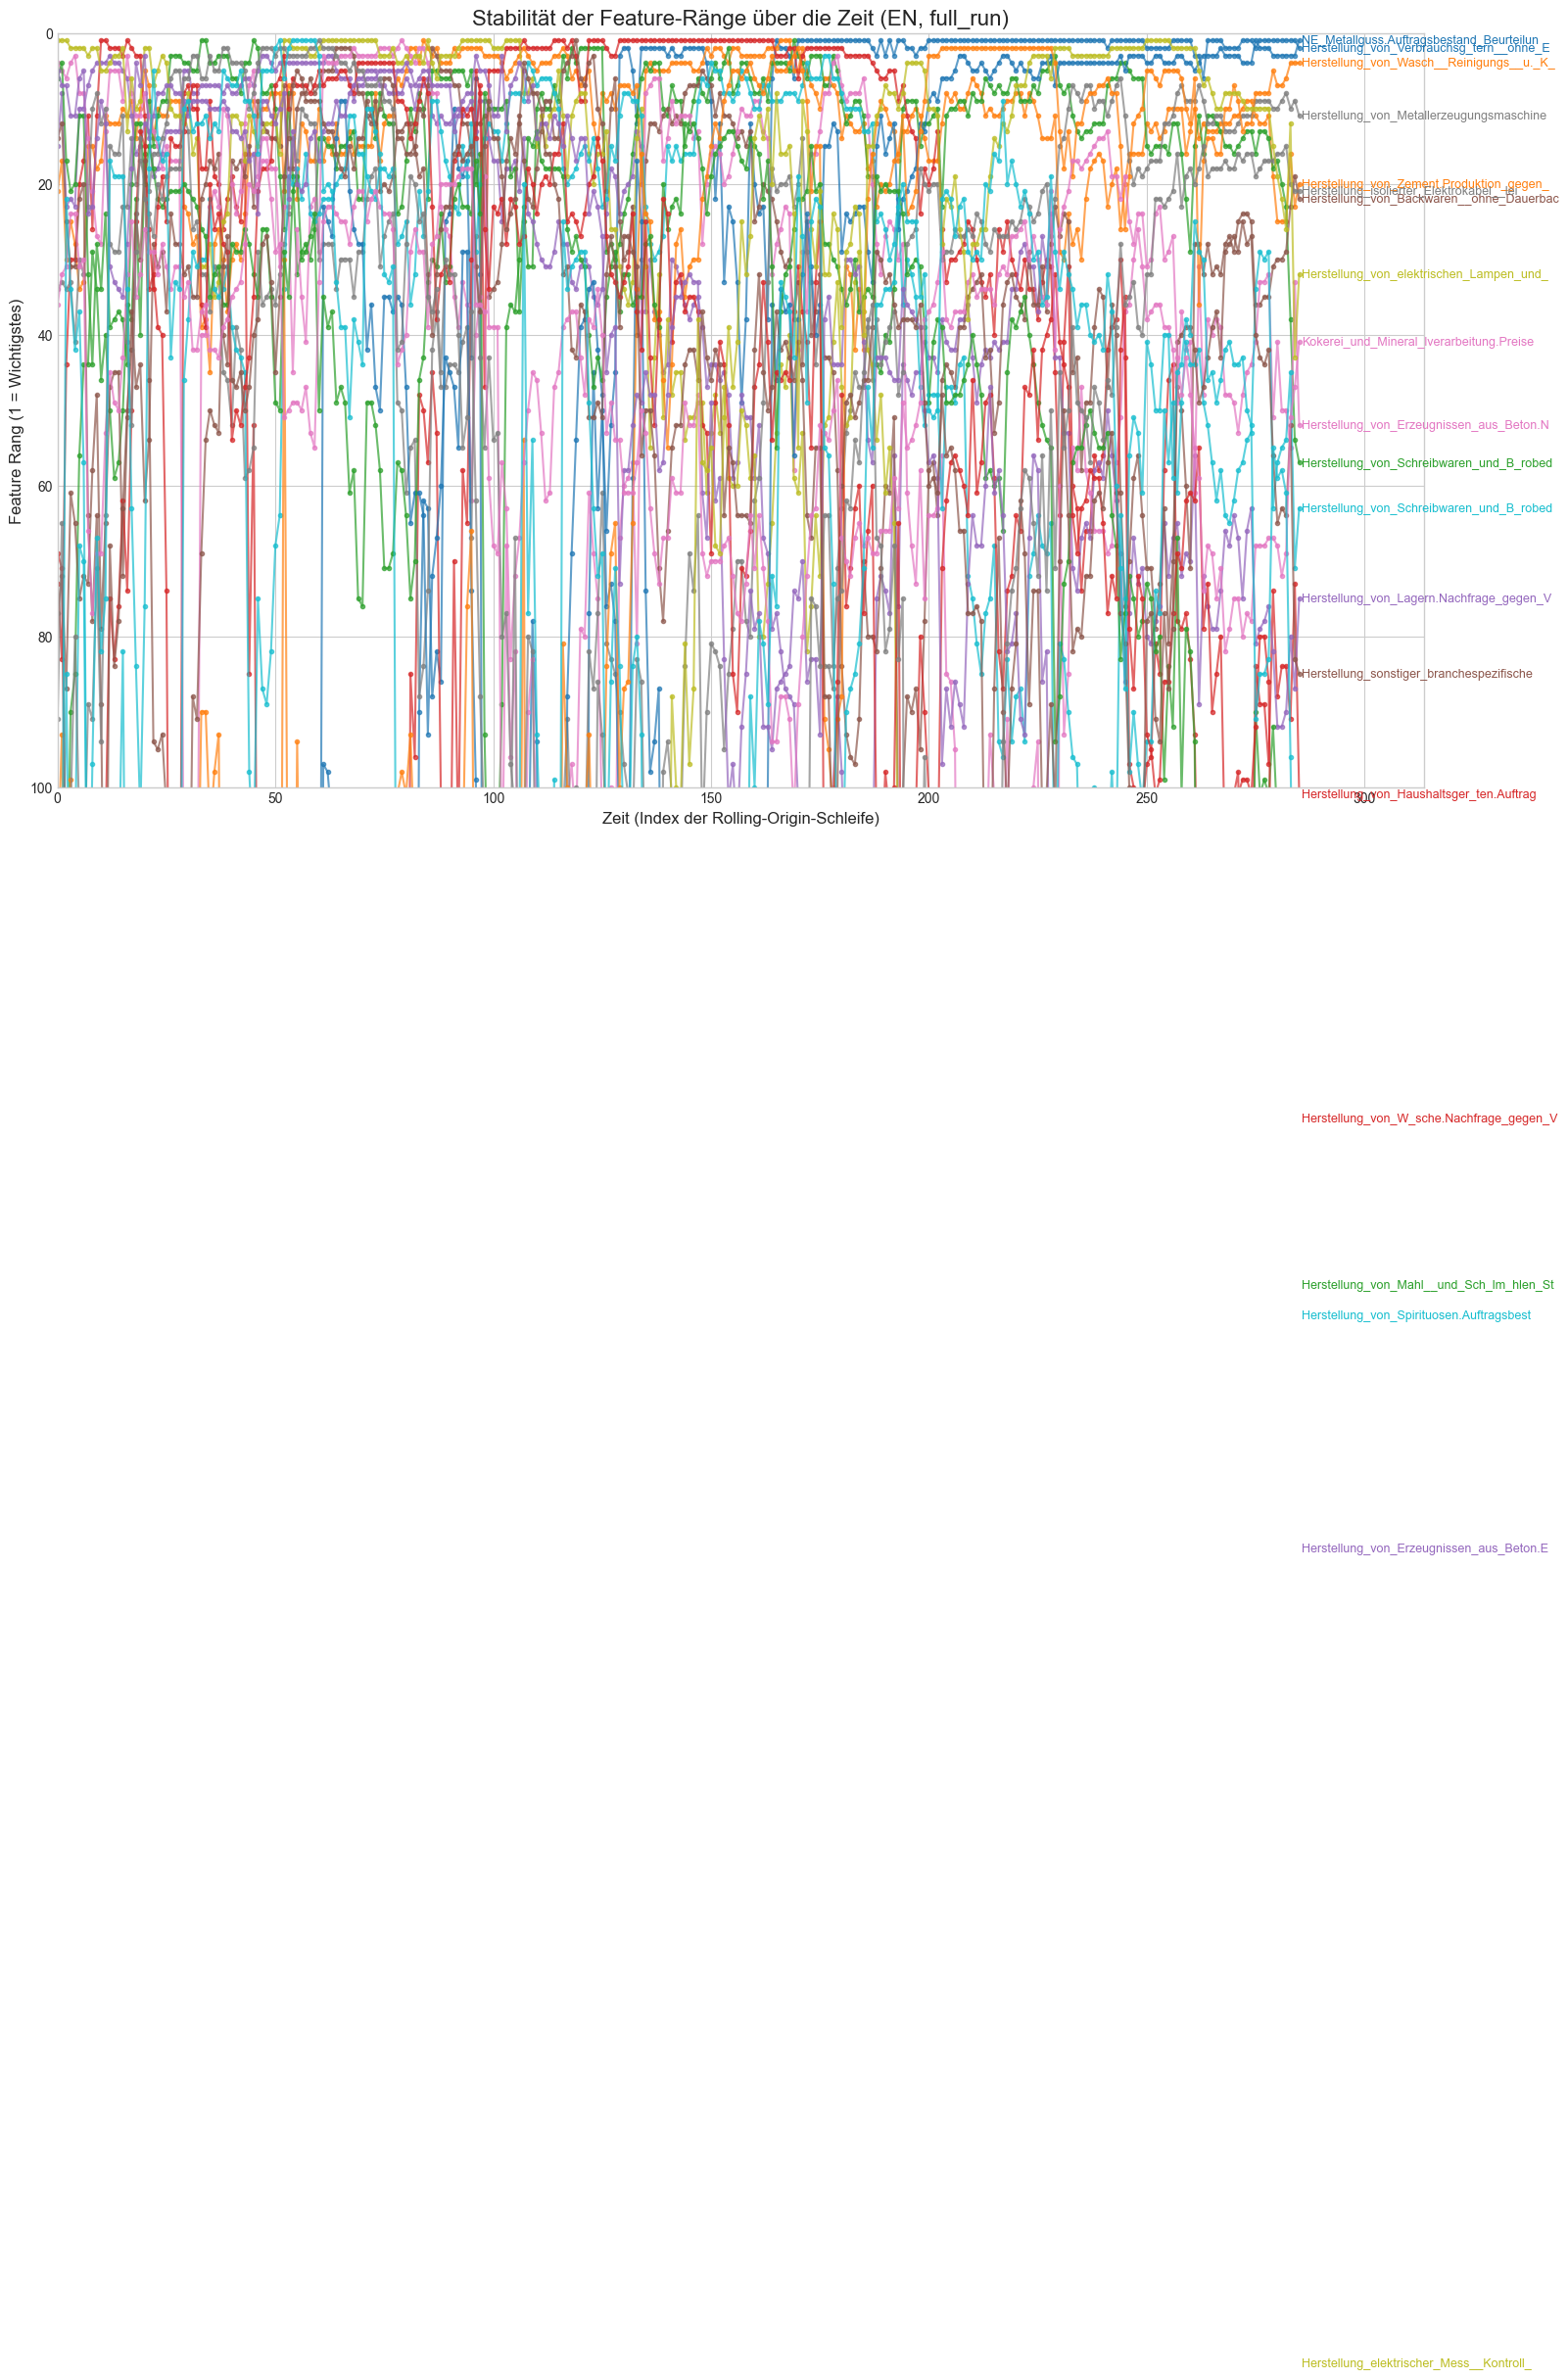

Stabilitäts-Plot gespeichert unter: /Users/jonasschernich/Documents/Masterarbeit/Code/outputs/feature_importance/outputs_no_missing/stability_plot_EN_full_run.png


In [5]:
# --- 7. Stabilitäts-Analyse der Feature Ranks über die Zeit ---
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd

print("Starte Stabilitäts-Analyse...")
MODEL_TO_PLOT = 'EN'  # Wähle 'EN', 'ET' or 'LGBM'
RUN_TO_PLOT = 'full_run'  # KORRIGIERT: Muss 'full_run' sein, um 'raw_importance..._full_run.csv' zu finden
N_FEATURES_TO_PLOT = 20  # Plotte die Top N Features

# --- 1. Lade die rohen Log-Daten ---
# OUTPUT_DIR wird aus der vorherigen Zelle übernommen (zeigt auf .../outputs_no_missing/)
raw_log_file = OUTPUT_DIR / f"raw_importance_{MODEL_TO_PLOT}_{RUN_TO_PLOT}.csv"

if not raw_log_file.exists():
    print(f"Log-Datei {raw_log_file} nicht gefunden. Überspringe Plot.")
    print("Stelle sicher, dass die obere Zelle (Hauptskript) vollständig durchgelaufen ist.")
else:
    print(f"Lade Daten für Stabilitäts-Plot aus {raw_log_file}")
    df_raw = pd.read_csv(raw_log_file, index_col=0)

    if df_raw.empty:
        print("Log-Datei ist leer. Überspringe Plot.")
    else:
        # --- 2. Berechne die Top N Features (im Durchschnitt) ---
        df_mean_imp = df_raw.mean(axis=0).sort_values(ascending=False)
        top_n_features = df_mean_imp.head(N_FEATURES_TO_PLOT).index.tolist()
        print(f"Top {N_FEATURES_TO_PLOT} Features (avg) für Plot:\n{top_n_features}")

        # --- 3. Berechne Ränge über die Zeit ---
        # Berechne den Rang für *alle* Features zu *jedem* Zeitpunkt
        df_ranks = df_raw.rank(axis=1, ascending=False, method='min')

        # Wähle nur die Ränge der Top-N Features aus
        df_top_ranks = df_ranks[top_n_features]

        # --- 4. Erstelle den Plot ---
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(18, 10))  # Größere Figur

        # Definiere ein Set an Farben
        colors = list(mcolors.TABLEAU_COLORS.values()) * 3  # 30 Farben

        # Plot lines
        for i, feature in enumerate(df_top_ranks.columns):
            ax.plot(
                df_top_ranks.index,
                df_top_ranks[feature],
                marker='o',
                markersize=3,
                linestyle='-',
                linewidth=1.5,
                alpha=0.7,
                label=feature,
                color=colors[i % len(colors)]
            )

        # Beschriftungen (optional, aber nützlich)
        # Füge Labels am Ende der Linien hinzu
        for i, feature in enumerate(df_top_ranks.columns):
            ax.text(
                df_top_ranks.index[-1] + 0.5,  # x-Position (am Ende)
                df_top_ranks[feature].iloc[-1],  # y-Position (letzter Rang)
                feature[:40],  # Gekürzter Feature-Name
                fontsize=9,
                verticalalignment='center',
                color=colors[i % len(colors)]
            )

        ax.set_title(f"Stabilität der Feature-Ränge über die Zeit ({MODEL_TO_PLOT}, {RUN_TO_PLOT})", fontsize=16)
        ax.set_xlabel("Zeit (Index der Rolling-Origin-Schleife)", fontsize=12)
        ax.set_ylabel("Feature Rang (1 = Wichtigstes)", fontsize=12)

        # Passe die x-Achsen-Limits an, um Platz für die Labels zu schaffen
        ax.set_xlim(df_top_ranks.index[0], df_top_ranks.index[-1] + (len(df_top_ranks.index) * 0.1))  # 10% Puffer

        # Setze y-Achsen-Limit (z.B. nur die Top 100 Ränge anzeigen)
        max_rank_display = max(100, N_FEATURES_TO_PLOT + 20)
        ax.set_ylim(max_rank_display, 0)  # Rang 1 ist oben

        plt.show()

        # Speichere den Plot
        # Der Plot wird automatisch in OUTPUT_DIR (.../outputs_no_missing/) gespeichert
        plot_path = OUTPUT_DIR / f"stability_plot_{MODEL_TO_PLOT}_{RUN_TO_PLOT}.png"
        fig.savefig(plot_path, dpi=150, bbox_inches='tight')
        print(f"Stabilitäts-Plot gespeichert unter: {plot_path}")